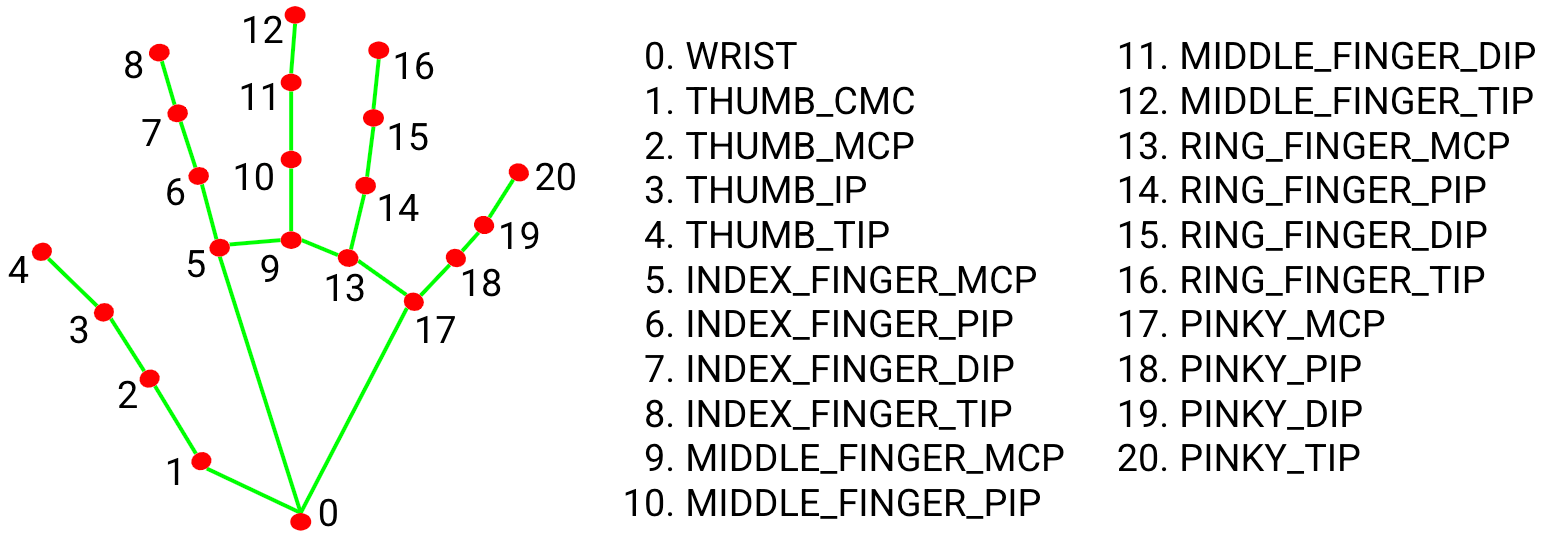

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import math
from IPython.display import display, Image ,clear_output
import time
import keyboard
from transitions import Machine

In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hand = mp_hands.Hands(max_num_hands=2, model_complexity=1, 
                      min_detection_confidence=0.5,min_tracking_confidence=0.5)

In [3]:
class HandAction():
    
    states = ['UNKNOWN', 'A1', 'A2', 'B1', 'B2',  'C1', 'C2', 'D']
    
    def __init__(self):
        
        self.cycle_count = 0
        
        self.machine = Machine(model = self, states =HandAction.states, initial = 'UNKNOWN',ignore_invalid_triggers = True)
        
        self.machine.add_transition(trigger = 'unknown', source = 'UNKNOWN', dest = 'UNKNOWN') #1
        self.machine.add_transition(trigger = 'a1', source = 'UNKNOWN', dest = 'A1') #2
        self.machine.add_transition(trigger = 'a2', source = 'UNKNOWN', dest = 'A2') #3
        self.machine.add_transition(trigger = 'unknown', source = 'A1', dest = 'UNKNOWN') #4
        self.machine.add_transition(trigger = 'unknown', source = 'A2', dest = 'UNKNOWN') #5
        self.machine.add_transition(trigger = 'b1', source = 'A1', dest = 'B1') #6
        self.machine.add_transition(trigger = 'b1', source = 'B1', dest = 'B1') #7
        self.machine.add_transition(trigger = 'unknown', source = 'B1', dest = 'B1') #8
        self.machine.add_transition(trigger = 'b2', source = 'A2', dest = 'B2') #9
        self.machine.add_transition(trigger = 'b2', source = 'B2', dest = 'B2') #10
        self.machine.add_transition(trigger = 'unknown', source = 'B2', dest = 'B2') #11
        self.machine.add_transition(trigger = 'c1', source = 'B1', dest = 'C1') #12
        self.machine.add_transition(trigger = 'c1', source = 'C1', dest = 'C1') #13
        self.machine.add_transition(trigger = 'unknown', source = 'C1', dest = 'UNKNOWN') #14
        self.machine.add_transition(trigger = 'c2', source = 'B2', dest = 'C2') #15
        self.machine.add_transition(trigger = 'c2', source = 'C2', dest = 'C2') #16
        self.machine.add_transition(trigger = 'unknown', source = 'C2', dest = 'UNKNOWN') #17
        self.machine.add_transition(trigger = 'a2', source = 'C1', dest = 'D') #18
        self.machine.add_transition(trigger = 'a2', source = 'D', dest = 'UNKNOWN', after = 'update_cycle_count') #19
        self.machine.add_transition(trigger = 'a1', source = 'C2', dest = 'D') #20
        self.machine.add_transition(trigger = 'a1', source = 'D', dest = 'UNKNOWN', after = 'update_cycle_count') #21
        self.machine.add_transition(trigger = 'a1', source = 'B1', dest = 'UNKNOWN') #22
        self.machine.add_transition(trigger = 'a2', source = 'B2', dest = 'UNKNOWN') #23
        
         
    def update_cycle_count(self):
        self.cycle_count += 1

In [4]:
def findHands(img, draw=True):
        """
        Finds hands in a BGR image.
        :param img: Image to find the hands in.
        :param draw: Flag to draw the output on the image.
        :return: Image with or without drawings
        """
        results = hand.process(img)
        allHands = []
        h, w, c = img.shape
        if  results.multi_hand_landmarks:
            for handType,handLms in zip(results.multi_handedness,results.multi_hand_landmarks):
                myHand={}
                ## lmList
                mylmList = []
                xList = []
                yList = []
                for id, lm in enumerate(handLms.landmark):
                    px, py = int(lm.x * w), int(lm.y * h)
                    mylmList.append([px, py])
                    xList.append(px)
                    yList.append(py)

                ## bbox
                xmin, xmax = min(xList), max(xList)
                ymin, ymax = min(yList), max(yList)
                boxW, boxH = xmax - xmin, ymax - ymin
                bbox = xmin, ymin, boxW, boxH
                cx, cy = bbox[0] + (bbox[2] // 2), \
                         bbox[1] + (bbox[3] // 2)

                myHand["lmList"] = mylmList
                myHand["bbox"] = bbox
                myHand["center"] =  (cx, cy)

                
                if handType.classification[0].label =="Right":
                    myHand["type"] = "Left"
                else:
                    myHand["type"] = "Right"
                allHands.append(myHand)

                ## draw
                if draw:
                    mp_drawing.draw_landmarks(img, handLms,
                                               mp_hands.HAND_CONNECTIONS,
                                              mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=2),
                                              mp_drawing.DrawingSpec(color=(0,255,255), thickness=2, circle_radius=2))
#                     cv2.rectangle(img, (bbox[0] - 20, bbox[1] - 20),
#                                   (bbox[0] + bbox[2] + 20, bbox[1] + bbox[3] + 20),
#                                   (255, 0, 255), 2)
                    # cv2.putText(img,myHand["type"],(bbox[0] - 30, bbox[1] - 30),cv2.FONT_HERSHEY_PLAIN,
                    #             2,(0, 255, 255),2)

            return allHands

In [5]:
def findPosition(allHands, img, handRL = 'Right' , landmarks_no = 0, draw=True):
    coordinate = []
    if allHands:
        for hand in allHands:
            if hand['type'] == handRL:
                x, y = hand['lmList'][landmarks_no][0], hand['lmList'][landmarks_no][1]
                coordinate.append(x)
                coordinate.append(y)
                if draw:
                    cv2.circle(img, (x, y), 5, (0, 255, 0), cv2.FILLED)
                    #cv2.putText(img, str(coordinate),(x, y), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return coordinate

In [6]:
def calculateAngle(allHands, img, handRL = 'Right' , joint_list = [0, 1, 2], draw=True):
    if allHands:
        for hand in allHands:
            if hand['type'] == handRL:
                angle = None
                a = np.array([hand['lmList'][joint_list[0]][0],hand['lmList'][joint_list[0]][1]])# First coord
                b = np.array([hand['lmList'][joint_list[1]][0],hand['lmList'][joint_list[1]][1]])# Second coord
                c = np.array([hand['lmList'][joint_list[2]][0],hand['lmList'][joint_list[2]][1]])# Third coord 
                radians = np.arctan2(c[1] - b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
                angle = np.abs(radians*180.0/np.pi)
                if angle > 180.0:
                    angle = 360-angle
                if draw:
                    cv2.putText(img, str(round(angle,2)),(b[0],b[1]), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                return angle

In [7]:
def calculateSpatialRelationship(img ,p1, p2, draw=True):  
    relationship = None
    if len(p1) == 2 & len(p2) == 2:
        if p1[1] < p2[1]:
            relationship = 'above'
        elif p1[1] > p2[1]:
            relationship = 'below'
    if draw:
        #(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
        cv2.putText(img,'relationship : ' +str(relationship), (20,100), 
                    cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)
    return relationship

In [8]:
def calculateDistance(img, p1, p2, draw=True):
    length = None
    if len(p1) == 2 & len(p2) == 2 :
        x1, y1 = p1
        x2, y2 = p2
        length = math.hypot(x2 - x1, y2 - y1)
        if draw:
            cv2.circle(img, (x1, y1), 5, (255, 0, 255), cv2.FILLED)
            cv2.circle(img, (x2, y2), 5, (255, 0, 255), cv2.FILLED)
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
    return length   

In [9]:
def calculateThreshold(distance,threshold, draw = True):
    if distance:
            if distance > threshold: 
                threshold = distance
    if draw:
         #(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
        cv2.putText(img,'threshold : ' +str(threshold), (20,100), 
                    cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)
    return threshold

In [10]:
def gestureDetection(img, angle_left_hand, angle_right_hand, distance_lift_rtt, distance_ltt_rift, threshold,
                    lift_ltt_spatial_relationship,rift_rtt_spatial_relationship, lpm_rpm_spatial_relationship, draw = True):
    if (angle_left_hand and angle_right_hand and distance_lift_rtt and distance_ltt_rift and lift_ltt_spatial_relationship\
        and rift_rtt_spatial_relationship and lpm_rpm_spatial_relationship) != None:
        
        if (angle_left_hand>70) and (angle_left_hand<130) and (angle_right_hand>70) and (angle_right_hand<130) and\
        (distance_lift_rtt<threshold*1.1) and (distance_ltt_rift<threshold*1.1) and (lpm_rpm_spatial_relationship == 'above'):
            gesture ="a1"
            
        elif ((distance_lift_rtt<threshold) and (distance_ltt_rift>threshold) and\
              (lift_ltt_spatial_relationship=='above') and (rift_rtt_spatial_relationship=='below')
             ):
            gesture ="b1"
            
        elif ((distance_lift_rtt<threshold) and (distance_ltt_rift>threshold) and\
              (lift_ltt_spatial_relationship=='below') and (rift_rtt_spatial_relationship=='above')
             ):
            gesture ="c1"
            
        elif (angle_left_hand>70) and (angle_left_hand<130) and (angle_right_hand>70) and (angle_right_hand<130) and\
        (distance_lift_rtt<threshold) and (distance_ltt_rift<threshold) and (lpm_rpm_spatial_relationship == 'below'):
            gesture ="a2"    
        
        elif ((distance_lift_rtt>threshold) and (distance_ltt_rift<threshold) and\
              (lift_ltt_spatial_relationship=='below') and (rift_rtt_spatial_relationship=='above')
             ):
            gesture ="b2"
        
        elif ((distance_lift_rtt>threshold) and (distance_ltt_rift<threshold) and\
              (lift_ltt_spatial_relationship=='above') and (rift_rtt_spatial_relationship=='below')
             ):
            gesture ="c2"
            
        else:
            gesture = "unknown"
        if draw:
            cv2.putText(img,'gesture : ' +str(gesture), (20,25), 
            cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)#(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
        return gesture
    

In [11]:
def showVideo(img, fps=30):     
    _, en_image = cv2.imencode('.jpg',img)
    img_obj = Image(data = en_image)
    clear_output(True)
    display(img_obj)
    time.sleep(1/fps)
    if keyboard.is_pressed('esc'):
        video.release()

In [12]:
def actionDetection(img, gesture , draw = True):
    if gesture=='unknown':
        hand_action_detector.unknown()
    elif gesture=='a1':
        hand_action_detector.a1()
    elif gesture=='b1':
        hand_action_detector.b1()
    elif gesture=='c1':
        hand_action_detector.c1()
    elif gesture=='a2':
        hand_action_detector.a2()
    elif gesture=='b2':
        hand_action_detector.b2()
    elif gesture=='c2':
        hand_action_detector.c2()
    
    if draw: 
        #(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
        # cv2.putText(img,'state : ' +str(hand_action_detector.state), (20,50), 
        #             cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)
        cv2.putText(img, ('count : '+str(hand_action_detector.cycle_count)), (10,60), 
                            cv2.FONT_HERSHEY_DUPLEX, 2, (0,  255, 0), 5, cv2.LINE_AA)       

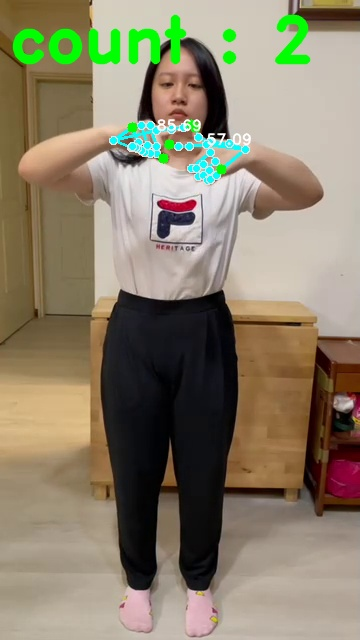

In [13]:
video = cv2.VideoCapture('../../video_data/(006)finger/OK.MOV')
#video = cv2.VideoCapture('C_31_NG1.MOV')
#video = cv2.VideoCapture('C_31_NG2.MOV')
#video = cv2.VideoCapture('C_31_NG3.MOV')


hand_action_detector = HandAction()

threshold = 0
frame_id = 0

while True:
    success, img = video.read()
    if not success:
        break
    if success:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create hand_action_detector instance    
        # Detection
        allHands = findHands(img, draw=1) 
        
        # Find landmark coordinate
        left_index_finger_tip = findPosition(allHands, img, handRL = 'Left' , landmarks_no = 8 , draw=True)
        right_index_finger_tip = findPosition(allHands, img, handRL = 'Right' , landmarks_no = 8 , draw=True)
        left_thumb_tip = findPosition(allHands, img, handRL = 'Left' , landmarks_no = 4 , draw=True)
        right_thumb_tip = findPosition(allHands, img, handRL = 'Right' , landmarks_no = 4 , draw=True)
        left_thumb_ip = findPosition(allHands, img, handRL = 'Left' , landmarks_no = 3 , draw=False)
        left_pinky_mcp = findPosition(allHands, img, handRL = 'Left' , landmarks_no = 17 , draw=1)
        right_pinky_mcp = findPosition(allHands, img, handRL = 'Right' , landmarks_no = 17 , draw=1)
        
        # Calculate purlicue angle 
        angle_left_hand = calculateAngle(allHands, img, handRL = 'Left' , joint_list = [4, 5, 8], draw=True)
        angle_right_hand = calculateAngle(allHands, img, handRL = 'Right' , joint_list = [4, 5, 8], draw=True)
        
        # Define distance threshold between index_finger_tip & thumb_tip
        distance = calculateDistance(img, left_thumb_tip, left_thumb_ip, draw = 0)
        threshold = calculateThreshold(distance, threshold, draw = 0)
        print(threshold)
              
        # Calculate distance between index_finger_tip & thumb_tip
        distance_lift_rtt = calculateDistance(img, left_index_finger_tip, right_thumb_tip, draw = 0)
        distance_ltt_rift = calculateDistance(img, left_thumb_tip, right_index_finger_tip, draw = 0)
        
        # Print distance_lift_rtt & distance_ltt_rift
#         cv2.putText(img,'threshold lift_rtt : ' +str(distance_lift_rtt), (20,100), 
#                     cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)
#         cv2.putText(img,'threshold ltt_rift: ' +str(distance_ltt_rift), (20,125), 
#                     cv2.FONT_HERSHEY_DUPLEX, 0.8, (0,  255, 0), 2, cv2.LINE_AA)
        
        
        # Calculate spatial relationship
        lift_ltt_spatial_relationship = calculateSpatialRelationship(img, p1 = left_index_finger_tip, p2 = left_thumb_tip, draw = 0)
        rift_rtt_spatial_relationship = calculateSpatialRelationship(img, p1 = right_index_finger_tip, p2 = right_thumb_tip, draw = 0)
        lpm_rpm_spatial_relationship = calculateSpatialRelationship(img, p1 = left_pinky_mcp, p2 =right_pinky_mcp, draw = 0)
               
        # Detect gesture
        gesture = gestureDetection(img, angle_left_hand, angle_right_hand, distance_lift_rtt, distance_ltt_rift, threshold,
                                   lift_ltt_spatial_relationship,rift_rtt_spatial_relationship, lpm_rpm_spatial_relationship, draw = 0)
        
        #Detect action
        actionDetection(img, gesture, draw = True)
                   
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        #save img
        cv2.imwrite('frame/'+str(frame_id).zfill(4)+'.jpg',img)
        frame_id += 1
        
        showVideo(img, fps = 30)
        if keyboard.is_pressed('esc'):
            break
video.release()